### Hadoop3.3 + Spark3.0 + IPython3.7 机器学习与大数据实战
## <center>网页分类引擎 >>> Kaggle 网页实效性分类项目</center>
## <center>基于决策树分类算法</center>
### <center>策略制定及验证：张君颖  ； 报告日期：2020.12.19</center>  
  
<font color=blue><center>作者邮箱：zhang.jun.ying@outlook.com</center></font>   
  
<font color=blue><center>项目源代码、数据、自定义函数已上传GitHub：</center></font>   
    
<font color=blue><center>https://github.com/lotbear/Python-Financial-investment-strategy</center></font>

### 网页实效性分类 >>> 数据描述
数据来源：https://www.kaggle.com/c/stumbleupon/data   

Kaggle 是一个数据分析的竞赛平台，也是 Crowdsourcing（众包）平台。本次报告针对该平台的一个项目 ——> StumbleUpon 项目，进行算法建模。  

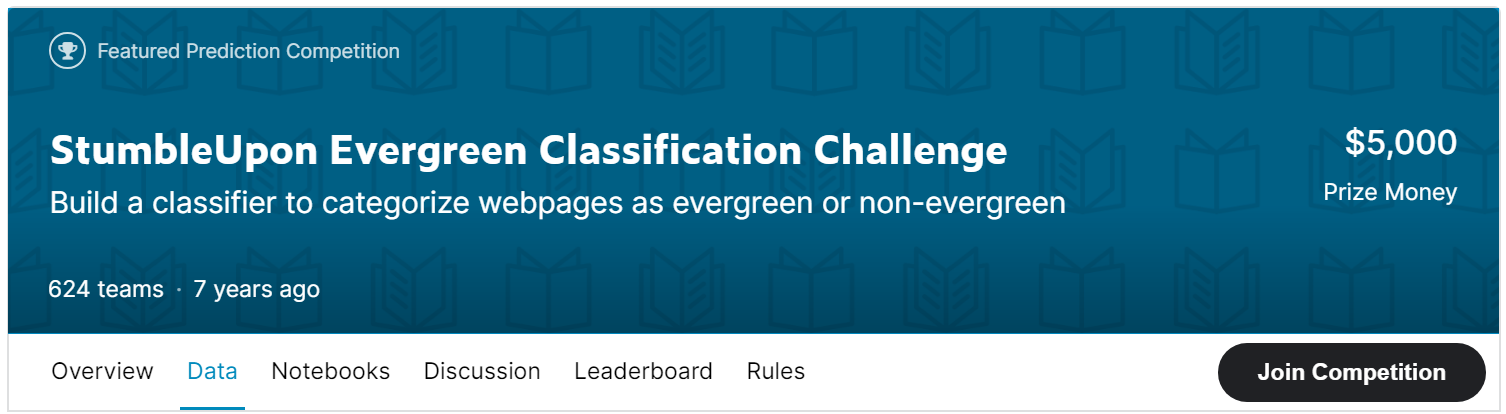

StumbleUpon 是个性化的搜索引擎，会按用户的兴趣和网页评分等记录，推荐给你感兴趣的网页。    

#### <font color=blue>本次任务为网页实效性分类，最终实现结果为：</font>     

#### <font color=blue>>>> 通过算法建模，将网页实效性分为 ephemeral（暂时型）和 evergreen（长青型）两类。</font>       

数据基本情况：   

该项目提供 2 个数据文件：train.tsv（训练集）  ;  test.tsv （测试集）      

训练集数据，数据总量：7395 个网页数据，变量数：26个，有分类标签（ label: ephemeral=0； evergreen=1 ）  

测试集数据，数据总量：3171 个网页数据，变量数：26个，无分类标签，需要模型预测出分类标签 

### 网页实效性分类 >>> 项目分析

#### 拿到数据后，我们首先要 “ 分析问题 ”：   

网页内容的实效性短的（ephemeral），比如 新闻热点 / 股市消息 / 季节性话题等；内容实效性长的（evergreen），比如 理财观念 / 读书笔记等。   

StumbleUpon 公司希望我们能帮助他们区分网页内容实效性，从而在内容推荐上更加智能。   

从算法工程角度，分析每个网页页面的关键词，并进行实效性建模是一种方案，但面对庞大的网页数据库，爬取每个页面的关键词再进行模型拟合，从实际应用角度，并不是一种讨巧的解决方案。   

#### <font color=blue>>>> 因此，我们设计的解决方案是：利用网页的特征属性（非页面内容）进行实效性判断</font>     

由于原数据中前 3 个变量对本次算法建模，不具有特征贡献，因此建模时会剔除。   

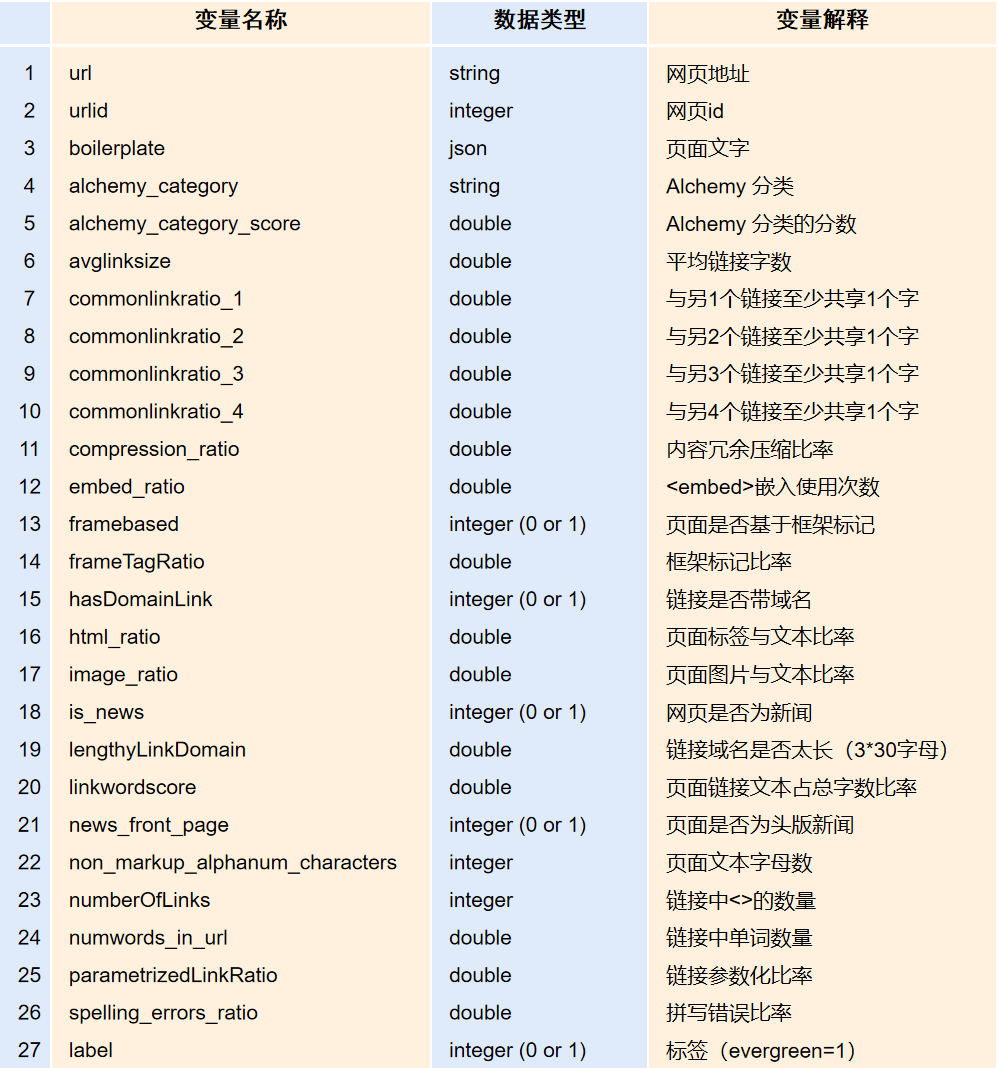

### 网页实效性分类 >>> 算法实战

### 第一步：数据上传 Hadoop-HDFS 分布式平台后，用 Saprk 命令读取/查看/处理。

In [1]:
# 查看 Spark 的运行模式，本次算法基于 Hadoop-yarn 架构
# 实现 4 台虚拟机同步进行的分布式运算
print('查看 Spark 的运行模式：',str(sc.master))

查看 Spark 的运行模式： yarn


In [2]:
# 设置全局数据集的路径
# 若 sc.master 查看显示的运行模式为 "local",则使用本地数据集
# 若 sc.master 查看显示的运行模式为其他，如 "yarn"，"spark://master:7077"(Standalone模式)
# 则选择 HDFS 上的数据集
global Path    
if sc.master[0:5]=="local" :
   Path="/home/lotbear/Big-Data/web_evergreen/"
else:   
   Path="hdfs://master:9000/user/lotbear/data/web_evergreen/"

In [3]:
print("开始导入数据...")
rawTrainData = sc.textFile(Path+"train.tsv")
print('训练集数据总量：',rawTrainData.count())

开始导入数据...
训练集数据总量： 7396


In [4]:
# 读取 rawUserData 第一行 “表头” 数据
rawTrainData.first().split("\t")

['"url"',
 '"urlid"',
 '"boilerplate"',
 '"alchemy_category"',
 '"alchemy_category_score"',
 '"avglinksize"',
 '"commonlinkratio_1"',
 '"commonlinkratio_2"',
 '"commonlinkratio_3"',
 '"commonlinkratio_4"',
 '"compression_ratio"',
 '"embed_ratio"',
 '"framebased"',
 '"frameTagRatio"',
 '"hasDomainLink"',
 '"html_ratio"',
 '"image_ratio"',
 '"is_news"',
 '"lengthyLinkDomain"',
 '"linkwordscore"',
 '"news_front_page"',
 '"non_markup_alphanum_characters"',
 '"numberOfLinks"',
 '"numwords_in_url"',
 '"parametrizedLinkRatio"',
 '"spelling_errors_ratio"',
 '"label"']

In [5]:
# 删除首行 “表头” 数据
# 将数据格式进行标准化
header = rawTrainData.first() 
rawTrainData = rawTrainData.filter(lambda x:x !=header)    
rData=rawTrainData.map(lambda x: x.replace("\"", ""))    
lines = rData.map(lambda x: x.split("\t"))

In [6]:
print('查看格式化后的数据，仅显示第一行：')
lines.first()[3:]

查看格式化后的数据，仅显示第一行：


['business',
 '0.789131',
 '2.055555556',
 '0.676470588',
 '0.205882353',
 '0.047058824',
 '0.023529412',
 '0.443783175',
 '0',
 '0',
 '0.09077381',
 '0',
 '0.245831182',
 '0.003883495',
 '1',
 '1',
 '24',
 '0',
 '5424',
 '170',
 '8',
 '0.152941176',
 '0.079129575',
 '0']

#### 由上可知，我们的变量数据中，1个分类 / 字符型数据，22个数值型数据   

我们需要将 “ 字符型 ” 数据进行数字编码，以方便后面的数据建模

In [7]:
# 将字符型型数据，进行字典型编码，每个 “ 分类/字符 ” 对应一个数字
categoriesMap =lines.map(lambda fields: fields[3]) \
        .distinct().zipWithIndex().collectAsMap()

In [8]:
categoriesMap

{'business': 0,
 'sports': 1,
 '?': 2,
 'arts_entertainment': 3,
 'gaming': 4,
 'culture_politics': 5,
 'computer_internet': 6,
 'law_crime': 7,
 'religion': 8,
 'weather': 9,
 'unknown': 10,
 'recreation': 11,
 'health': 12,
 'science_technology': 13}

In [9]:
# 查看字符型变量 类型总数
len(categoriesMap)

14

In [10]:
# 查看字符型变量 数据类别（字典）
type(categoriesMap)

dict

In [11]:
# 定义 特征变量提取 函数
# 以字典 key-value 查询方式，将字符数据全部转换为数字id --> categoryIdx
# 再将14个数字id，转换为 one-hot（独热编码）--> categoryFeatures
# 最后将编码后的14个分类变量 + 22个数值变量 合并
import numpy as np
def extract_features(field,categoriesMap,featureEnd):
    #提取分类特征字段
    categoryIdx = categoriesMap[field[3]] 
    categoryFeatures = np.zeros(len(categoriesMap))
    categoryFeatures[categoryIdx] = 1
    #提取数值字段
    numericalFeatures=[convert_float(field)  for  field in field[4: featureEnd]]    
    #返回“分类特征字段”+“数值特征字段”
    return  np.concatenate(( categoryFeatures, numericalFeatures))

def convert_float(x):
    return (0 if x=="?" else float(x))

In [12]:
# 定义函数，提取最后一列变量（分类标签变量）
def extract_label(field):
    label=(field[-1])
    return float(label)

In [13]:
# 用 map 命令实现 分类标签的提取
labelRDD = lines.map( lambda r: extract_label(r))
print(labelRDD.take(1))

[0.0]


In [14]:
# 导入 LabeledPoint 转换函数（label+features)
# 用 map 命令，将数据格式转换为 LabeledPoint 格式
from pyspark.mllib.regression import LabeledPoint
labelpointRDD = lines.map( lambda r: LabeledPoint(extract_label(r),
                extract_features(r,categoriesMap,len(r) - 1)))

In [15]:
# 显示转换后第一行 LabeledPoint 的数据
labelpointRDD.take(1)

[LabeledPoint(0.0, [1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.789131,2.055555556,0.676470588,0.205882353,0.047058824,0.023529412,0.443783175,0.0,0.0,0.09077381,0.0,0.245831182,0.003883495,1.0,1.0,24.0,0.0,5424.0,170.0,8.0,0.152941176,0.079129575])]

In [16]:
# 将总体数据，按 8：1：1比例，随即切分为 训练数据集 / 验证数据集 / 测试数据集
(trainData, validationData, testData) = labelpointRDD.randomSplit([8, 1, 1])
print("将数据分trainData:" + str(trainData.count()) +   
          "   validationData:" + str(validationData.count()) + 
          "   testData:" + str(testData.count()))


将数据分trainData:5929   validationData:737   testData:729


#### <font color=blue>将以上全部数据 处理 / 准备 工作，用一个函数进行集合，方便重复调用</font>

In [17]:
# 将以上全部数据 处理 / 准备 工作，用一个函数进行集合，方便重复调用
def PrepareData(sc): 
    #----------------------1.导入并转换数据-------------
    global Path    
    if sc.master[0:5]=="local" :
       Path="/home/lotbear/Big-Data/web_evergreen/"
    else:   
       Path="hdfs://master:9000/user/lotbear/data/web_evergreen/"

    print("开始导入数据...")
    rawDataWithHeader = sc.textFile(Path+"train.tsv")
    header = rawDataWithHeader.first() 
    rawData = rawDataWithHeader.filter(lambda x:x !=header)    
    rData=rawData.map(lambda x: x.replace("\"", ""))    
    lines = rData.map(lambda x: x.split("\t"))
    print("共计：" + str(lines.count()) + "项")
    #----------2.建立训练评估所需数据 RDD[LabeledPoint]-------    
    categoriesMap = lines.map(lambda fields: fields[3]).\
                                   distinct().zipWithIndex().collectAsMap()
    labelpointRDD = lines.map( lambda r:
               LabeledPoint(
                      extract_label(r), 
                      extract_features(r,categoriesMap,-1)))
    
    labelpointRDDFeaturesInfo = lines.map( lambda r:LabeledPoint(
                 extract_label(r), 
                 extract_features_FeaturesInfo(r,categoriesMap,len(r) - 1)))
        
    #-----------3.以随机方式将数据分为3个部分并且返回-------------
    (trainData, validationData, testData) = labelpointRDD.randomSplit([8, 1, 1])
    print("将数据分trainData:" + str(trainData.count()) + 
              "   validationData:" + str(validationData.count()) +
              "   testData:" + str(testData.count()))
    return (trainData, validationData, testData, categoriesMap) #返回数据


In [18]:
(trainData, validationData, testData, categoriesMap) =PrepareData(sc)

开始导入数据...
共计：7395项
将数据分trainData:5914   validationData:751   testData:730


In [19]:
# 将三个数据集 进行持久化，方便调用计算
trainData.persist()
validationData.persist()
testData.persist()

PythonRDD[32] at RDD at PythonRDD.scala:53

### 第二步：使用决策树模型（DecisionTree）训练数据

In [20]:
# 导入 DecisionTree 模型，训练数据，并将模型存入 model
# 参数 impurity 为模型评估方法（ gini系数 / entropy 熵 ）
# 参数 maxDepth 决策树最大深度, maxBins 每个节点最大分支数
from pyspark.mllib.tree import DecisionTree
model=DecisionTree.trainClassifier( \
        trainData, numClasses=2, categoricalFeaturesInfo={}, \
        impurity="entropy", maxDepth=5, maxBins=5)

#### <font color=blue>决策树模型预测</font>

In [21]:
# 定义 数据预测函数
# 先对 测试集数据进行预处理
# 再用已经训练好的 model 进行 “测试集数据” 拟合
# 显示 10 条预测结果
def PredictData(sc,model,categoriesMap): 
    print("开始导入数据...")
    rawDataWithHeader = sc.textFile(Path+"test.tsv")
    header = rawDataWithHeader.first() 
    rawData = rawDataWithHeader.filter(lambda x:x !=header)    
    rData=rawData.map(lambda x: x.replace("\"", ""))    
    lines = rData.map(lambda x: x.split("\t"))
    print("共计：" + str(lines.count()) + "项")
    dataRDD = lines.map(lambda r:  ( r[0]  ,
                            extract_features(r,categoriesMap,len(r) )))
    DescDict = {
           0: "暂时性网页(ephemeral)",
           1: "长青网页(evergreen)"
     }
    for data in dataRDD.take(10):
        predictResult = model.predict(data[1])
        print(" 网址：  " +str(data[0])+"\n" +\
                  "             ==>预测:"+ str(predictResult)+ \
                  " 说明:"+DescDict[predictResult] +"\n")

In [22]:
print("==========预测数据===============")
PredictData(sc, model, categoriesMap)

==========预测数据===============
开始导入数据...
共计：3171项
 网址：  http://www.lynnskitchenadventures.com/2009/04/homemade-enchilada-sauce.html
             ==>预测:1.0 说明:长青网页(evergreen)

 网址：  http://lolpics.se/18552-stun-grenade-ar
             ==>预测:0.0 说明:暂时性网页(ephemeral)

 网址：  http://www.xcelerationfitness.com/treadmills.html
             ==>预测:0.0 说明:暂时性网页(ephemeral)

 网址：  http://www.bloomberg.com/news/2012-02-06/syria-s-assad-deploys-tactics-of-father-to-crush-revolt-threatening-reign.html
             ==>预测:0.0 说明:暂时性网页(ephemeral)

 网址：  http://www.wired.com/gadgetlab/2011/12/stem-turns-lemons-and-limes-into-juicy-atomizers/
             ==>预测:0.0 说明:暂时性网页(ephemeral)

 网址：  http://www.latimes.com/health/boostershots/la-heb-fat-tax-denmark-20111013,0,2603132.story
             ==>预测:0.0 说明:暂时性网页(ephemeral)

 网址：  http://www.howlifeworks.com/a/a?AG_ID=1186&cid=7340ci
             ==>预测:1.0 说明:长青网页(evergreen)

 网址：  http://romancingthestoveblog.wordpress.com/2010/01/13/sweet-potato-ravioli-wi

#### <font color=blue>评估决策树模型的准确率</font>  

用模型预测的 验证集分类标签数据 vs 验证集真实的分类标签数据   


In [23]:
# 由于之前我们已经将整个数据集进行了 labelpoint 处理
# 因此，验证集数据 validationData 可直接调用 features / label 属性，进行模型拟合
# 用模型预测的 验证集分类标签数据 vs 验证集真实的分类标签数据 
# 显示 5 组预测分类 vs 真实分类对比 （预测，真实）
score = model.predict(validationData.map(lambda p: p.features))
scoreAndLabels=score .zip(validationData.map(lambda p: p.label))
scoreAndLabels.take(5)

[(1.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0)]

In [24]:
# 导入 二元分类模型的评估指标 ROC-AUC 
# AUC取值在 0～1，大于0.5，视为模型比随机分类有效，越接近 1 模型越好
from pyspark.mllib.evaluation import BinaryClassificationMetrics
metrics = BinaryClassificationMetrics(scoreAndLabels)
print("AUC="+str(metrics.areaUnderROC))

AUC=0.6411893897394346


In [25]:
# 将以上模型评估过程，用一个函数进行集合，方便多次调用
def evaluateModel(model, validationData):
    score = model.predict(validationData.map(lambda p: p.features))
    scoreAndLabels=score.zip(validationData.map(lambda p: p.label))
    metrics = BinaryClassificationMetrics(scoreAndLabels)
    AUC=metrics.areaUnderROC
    return( AUC)

In [26]:
AUC=evaluateModel(model, validationData)
print("AUC="+str(AUC))

AUC=0.6411893897394346


In [27]:
# 导入时间参数，显示模型整个 训练+评估 所消耗的时间
from time import time
def trainEvaluateModel(trainData,validationData,
                      impurityParm, maxDepthParm, maxBinsParm):
    startTime = time()
    model = DecisionTree.trainClassifier(trainData,
                numClasses=2, categoricalFeaturesInfo={}, impurity=impurityParm,
                maxDepth=maxDepthParm, maxBins=maxBinsParm)
    AUC = evaluateModel(model, validationData)
    duration = time() - startTime
    print("训练评估：使用参数" + \
                " impurity="+str(impurityParm) +\
                " maxDepth="+str(maxDepthParm) + \
                " maxBins="+str(maxBinsParm) +"\n" +\
                 " ==>所需时间="+str(duration) + \
                 " 结果AUC = " + str(AUC))
    return (AUC,duration, impurityParm, maxDepthParm, maxBinsParm,model)

In [28]:
(AUC,duration, impurityParm, maxDepthParm, maxBinsParm,model)=  \
       trainEvaluateModel(trainData, validationData, "entropy", 5, 5)

训练评估：使用参数 impurity=entropy maxDepth=5 maxBins=5
 ==>所需时间=3.1113381385803223 结果AUC = 0.6411893897394346


### >>> 寻找模型最佳训练参数

In [29]:
impurityList=["gini", "entropy"]
maxDepthList  =[10]
maxBinsList=[10 ]

metrics = [trainEvaluateModel(trainData, validationData,  
                              impurity,maxDepth,  maxBins  ) 
                 for impurity in impurityList 
                 for maxDepth in maxDepthList  
                 for maxBins in maxBinsList ]

训练评估：使用参数 impurity=gini maxDepth=10 maxBins=10
 ==>所需时间=3.9401326179504395 结果AUC = 0.6216363171137361
训练评估：使用参数 impurity=entropy maxDepth=10 maxBins=10
 ==>所需时间=3.089383840560913 结果AUC = 0.6388936273046469


In [30]:
# 导入 pandas 包，将模型的关键参数，以 DataFrame 数据格式显示
import pandas as pd
IndexList=impurityList
df = pd.DataFrame(metrics,index=IndexList,
            columns=['AUC', 'duration','impurity', 'maxDepth', 'maxBins','model'])
df

,AUC,duration,impurity,maxDepth,maxBins,model
gini,0.621636,3.940133,gini,10,10,DecisionTreeModel classifier of depth 10 with ...
entropy,0.638894,3.089384,entropy,10,10,DecisionTreeModel classifier of depth 10 with ...


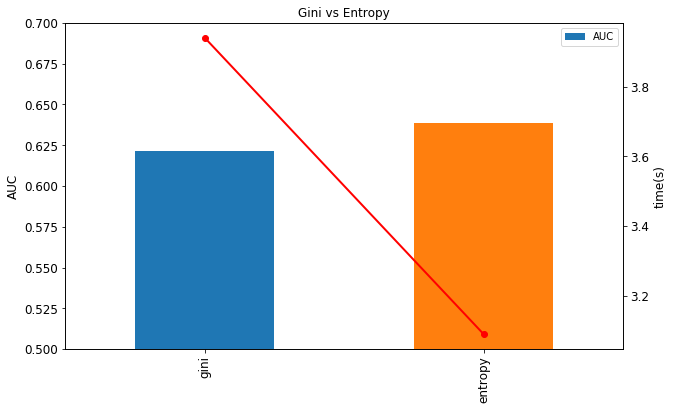

In [31]:
# 将模型指标可视化
# 导入 matplotlib 工具包
import matplotlib.pyplot as plt  
%matplotlib inline 
ax = df['AUC'].plot(kind='bar',title='Gini vs Entropy',
                    figsize=(10,6),legend=True,fontsize=12)
ax.set_ylim([0.5,0.7])
ax.set_ylabel("AUC",fontsize=12)
# 双纵坐标
ax2 = ax.twinx()
ax2.set_ylabel("time(s)",fontsize=12)
ax2.plot(df['duration'].values, linestyle='-', marker='o', 
         linewidth=2.0,color='r')
plt.yticks(fontsize=12)
plt.show()

In [32]:
# 将以上制图过程，用函数进行集合，方便多次调用
import matplotlib.pyplot as plt
%matplotlib inline 
def showchart(df,evalparm,barData,lineData,yMin,yMax):
    ax = df[barData].plot(kind='bar', title =evalparm,
                                         figsize=(10,6),legend=True, fontsize=12)
    ax.set_xlabel(evalparm,fontsize=12)
    ax.set_ylim([yMin,yMax])
    ax.set_ylabel(barData,fontsize=12)
    ax2 = ax.twinx()
    ax2.set_ylabel("time(s)",fontsize=12)
    ax2.plot(df[lineData ].values, linestyle='-', marker='o',
                    linewidth=2.0,color='r')
    plt.yticks(fontsize=12)
    plt.show()

In [33]:
# 定义 evalParameter 函数
def evalParameter(trainData, validationData, evalparm,
                  impurityList, maxDepthList, maxBinsList):
    #训练评估参数
    metrics = [trainEvaluateModel(trainData, validationData,  
                                impurity,maxDepth,  maxBins  ) 
                       for impurity in impurityList
                       for maxDepth in maxDepthList  
                       for maxBins in maxBinsList ]
    #设置当前评估的参数
    if evalparm=="impurity":
        IndexList=impurityList[:]
    elif evalparm=="maxDepth":
        IndexList=maxDepthList[:]
    elif evalparm=="maxBins":
        IndexList=maxBinsList[:]
    #转换为Pandas DataFrame
    df = pd.DataFrame(metrics,index=IndexList,
            columns=['AUC', 'duration','impurity', 'maxDepth', 'maxBins','model'])
    #显示图形
    showchart(df,evalparm,'AUC','duration',0.5,0.7 )  

训练评估：使用参数 impurity=gini maxDepth=3 maxBins=10
 ==>所需时间=2.1588857173919678 结果AUC = 0.6332714970076905
训练评估：使用参数 impurity=gini maxDepth=5 maxBins=10
 ==>所需时间=2.4454426765441895 结果AUC = 0.6173895119905611
训练评估：使用参数 impurity=gini maxDepth=10 maxBins=10
 ==>所需时间=3.474806308746338 结果AUC = 0.6216363171137361
训练评估：使用参数 impurity=gini maxDepth=15 maxBins=10
 ==>所需时间=3.2443532943725586 结果AUC = 0.6300162053818927
训练评估：使用参数 impurity=gini maxDepth=20 maxBins=10
 ==>所需时间=3.592284917831421 结果AUC = 0.6287439407508494
训练评估：使用参数 impurity=gini maxDepth=25 maxBins=10
 ==>所需时间=4.115400075912476 结果AUC = 0.6301405887955421


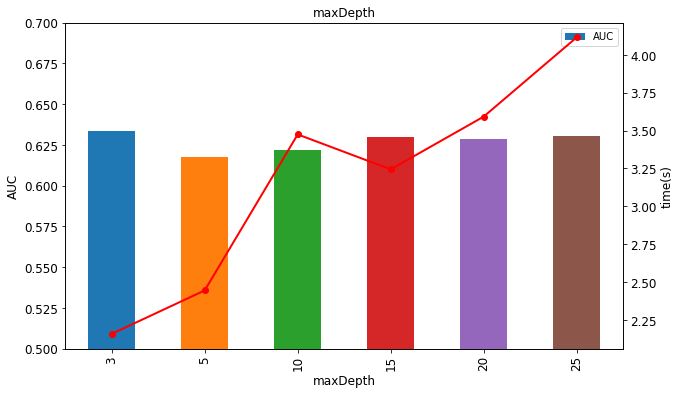

In [34]:
evalParameter(trainData, validationData,"maxDepth", 
                          impurityList=["gini"],                    
                          maxDepthList=[3, 5, 10, 15, 20, 25],    
                          maxBinsList=[10])   

训练评估：使用参数 impurity=gini maxDepth=10 maxBins=3
 ==>所需时间=2.4796643257141113 结果AUC = 0.6461256343554097
训练评估：使用参数 impurity=gini maxDepth=10 maxBins=5
 ==>所需时间=2.3438103199005127 结果AUC = 0.6251368217550144
训练评估：使用参数 impurity=gini maxDepth=10 maxBins=10
 ==>所需时间=2.0724897384643555 结果AUC = 0.6216363171137361
训练评估：使用参数 impurity=gini maxDepth=10 maxBins=50
 ==>所需时间=2.368859052658081 结果AUC = 0.5988883676631555
训练评估：使用参数 impurity=gini maxDepth=10 maxBins=100
 ==>所需时间=2.1184990406036377 结果AUC = 0.6308193668528863
训练评估：使用参数 impurity=gini maxDepth=10 maxBins=200
 ==>所需时间=2.2376444339752197 结果AUC = 0.6164513056704621


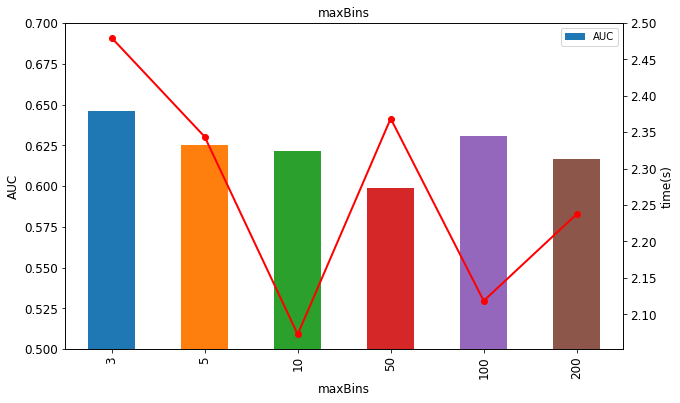

In [35]:
evalParameter(trainData, validationData,"maxBins", 
                          impurityList=["gini"],      
                          maxDepthList =[10],        
                          maxBinsList=[3, 5, 10, 50, 100, 200 ])

#### 找出准确率最高的参数组合

In [36]:
#定义evalAllParameter函数
def evalAllParameter(trainData, validationData, 
                     impurityList, maxDepthList, maxBinsList):    
    #for循环训练评估所有参数组合
    metrics = [trainEvaluateModel(trainData, validationData,  
                            impurity,maxDepth,  maxBins  ) 
                      for impurity in impurityList 
                      for maxDepth in maxDepthList  
                      for  maxBins in maxBinsList ]
    #找出AUC最大的参数组合
    Smetrics = sorted(metrics, key=lambda k: k[0], reverse=True)
    bestParameter=Smetrics[0]
    #显示调校后最佳参数组合
    print('='*50)
    print("调校后最佳参数：impurity:" + str(bestParameter[2]) + 
                                      ",maxDepth:" + str(bestParameter[3]) + 
                                     ",maxBins:" + str(bestParameter[4])   + 
                                      "\n,    结果AUC = " + str(bestParameter[0]))
    #返回最佳模型
    return bestParameter[5]

In [37]:
print("-----所有参数训练评估找出最好的参数组合---------")  
#  暴力求最优解，这部分求最优参数的算法可以优化
bestModel=evalAllParameter(trainData, validationData,
                          ["gini", "entropy"],
                          [3, 5, 15], 
                          [5, 50, 200])

-----所有参数训练评估找出最好的参数组合---------
训练评估：使用参数 impurity=gini maxDepth=3 maxBins=5
 ==>所需时间=1.438169240951538 结果AUC = 0.598771091873143
训练评估：使用参数 impurity=gini maxDepth=3 maxBins=50
 ==>所需时间=1.4973652362823486 结果AUC = 0.6367151406598718
训练评估：使用参数 impurity=gini maxDepth=3 maxBins=200
 ==>所需时间=1.315504789352417 结果AUC = 0.6106621462180335
训练评估：使用参数 impurity=gini maxDepth=5 maxBins=5
 ==>所需时间=1.3817389011383057 结果AUC = 0.6438583024151705
训练评估：使用参数 impurity=gini maxDepth=5 maxBins=50
 ==>所需时间=1.369645595550537 结果AUC = 0.6087608568951057
训练评估：使用参数 impurity=gini maxDepth=5 maxBins=200
 ==>所需时间=1.4181602001190186 结果AUC = 0.662224401893471
训练评估：使用参数 impurity=gini maxDepth=15 maxBins=5
 ==>所需时间=2.235403299331665 结果AUC = 0.64398268582882
训练评估：使用参数 impurity=gini maxDepth=15 maxBins=50
 ==>所需时间=3.033308267593384 结果AUC = 0.6094112044579015
训练评估：使用参数 impurity=gini maxDepth=15 maxBins=200
 ==>所需时间=3.1488287448883057 结果AUC = 0.5668614155543237
训练评估：使用参数 impurity=entropy maxDepth=3 maxBins=5
 ==>所需时间=0.990829

### 确认是否Overfitting（过度训练）?

如果训练集 trainData 得到的模型评估值 AUC 很高   

而测试集 testData  得到的模型评估值 AUC 很差，则出现模型过拟合问题

In [38]:
trainAUC=evaluateModel(model, trainData)
print("train 训练集 AUC="+str(trainAUC))
print('='*50)
validationAUC=evaluateModel(model, validationData)
print("validation 验证集 AUC="+str(validationAUC))
print('='*50)
testAUC=evaluateModel(model, testData)
print("test 测试集 AUC="+str(testAUC))

train 训练集 AUC=0.6623650229100579
validation 验证集 AUC=0.6411893897394346
test 测试集 AUC=0.6647929949459677


小结： 从数据来看，训练集 / 验证集 / 测试集 的 AUC 指标相差不大，模型不存在过拟合现象。

### >>> 本报告运行的软件架构

Linux-Ubuntu 20.10 + Hadoop 3.3 + Spark 3 + Java 11 + Scala 2.12 + Python 3.7 + Anaconda 3    

1 台 master 主机，负责 HDFS：NameNode + MapReduce（Yarn）：ResourceManager    

3 台 data 辅助计算机，负责 HDFS：DataNode + MapReduce（Yarn）：NodeManager   

所有 HDFS 文件分布式存储在 4 台电脑上，且各有 3 份备份    

具体配置过程，请参见作者另一篇报告《Hadoop+Spark+IPython>>>RDD大数据分布式运算（基础篇）》   

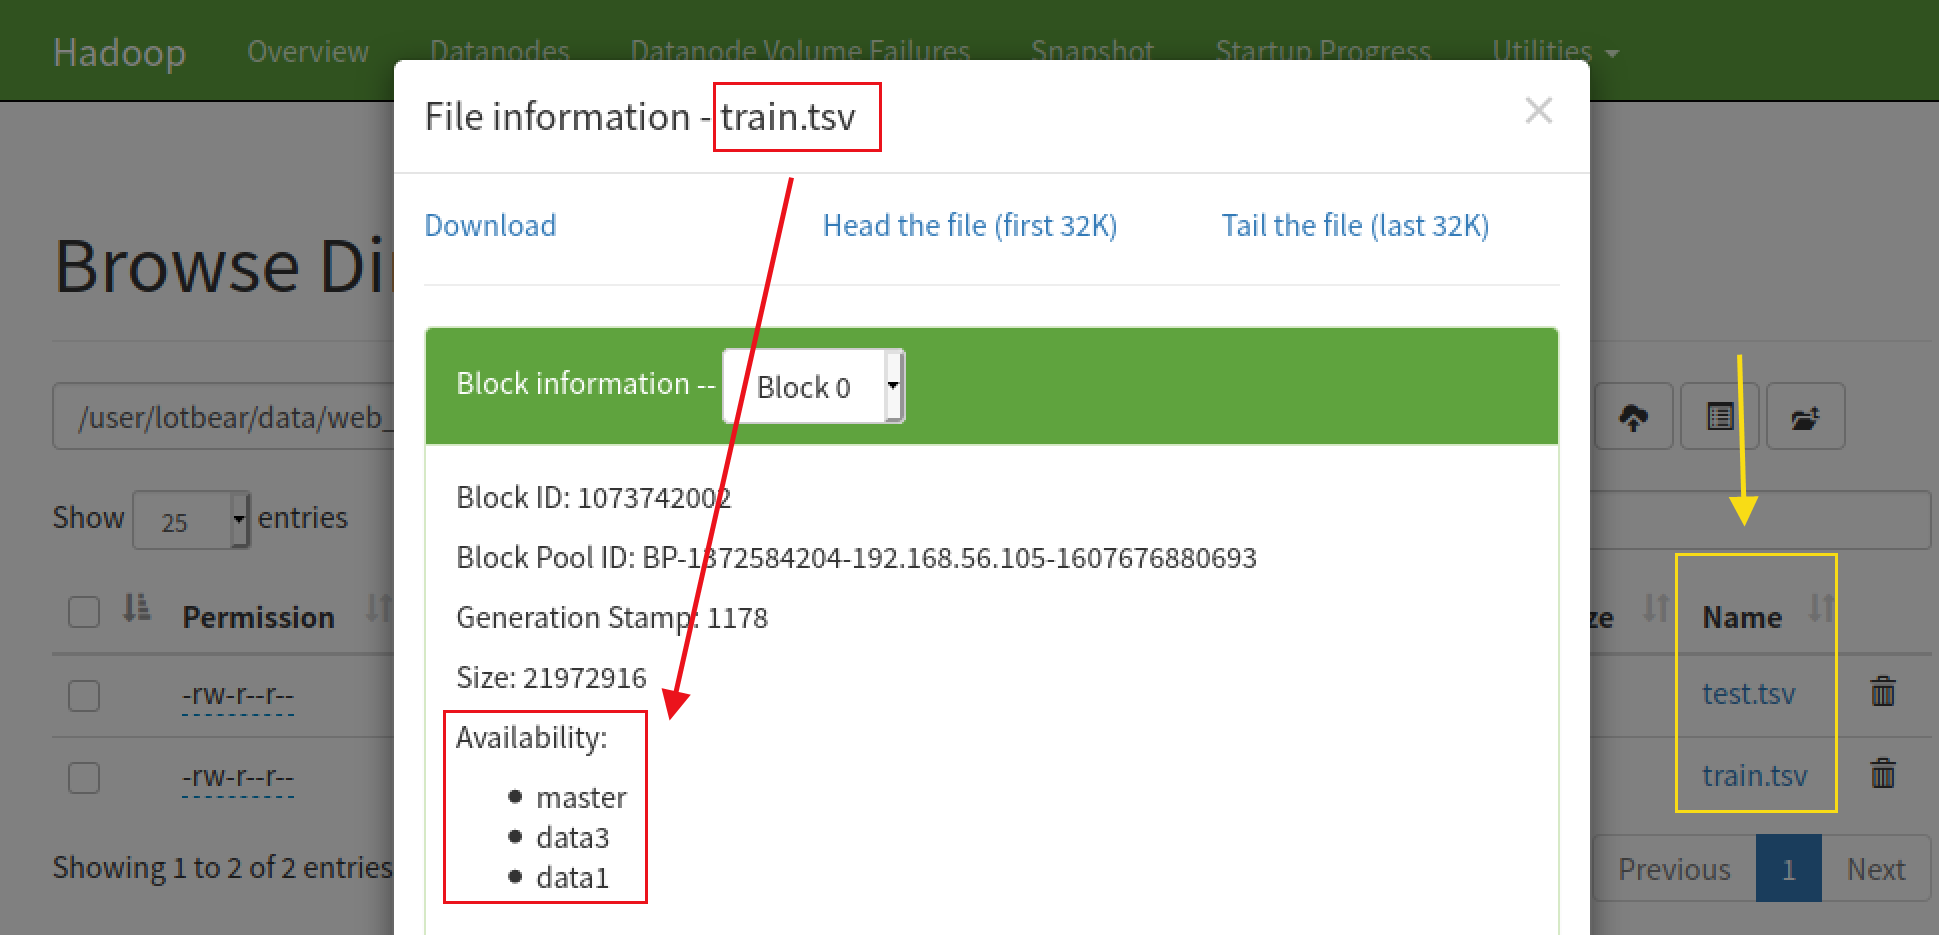

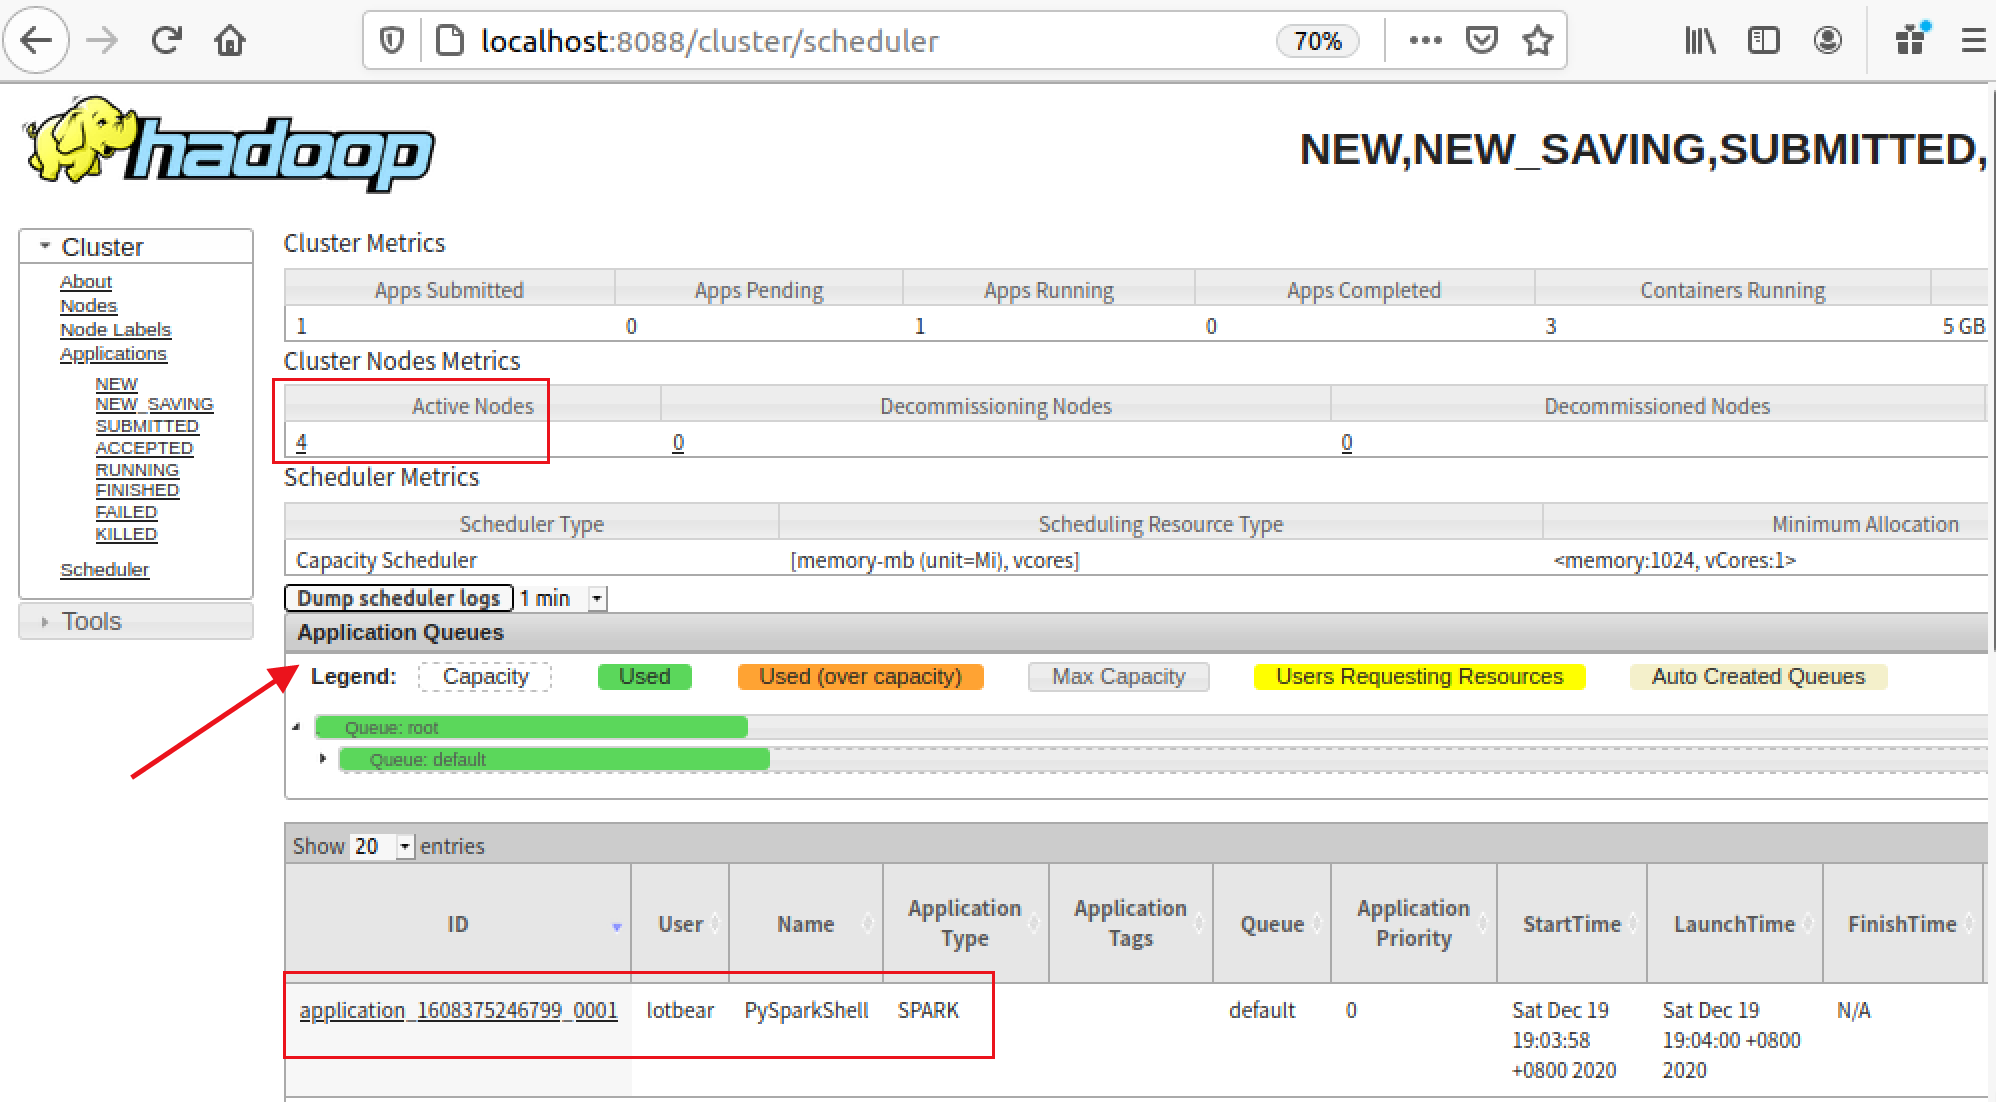